In [1]:
from PIL import Image
from random import randint
import numpy as np
import pandas as pd
import sys
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import torchvision
import warnings
import functools
import os


%matplotlib notebook

class datasetFactory(object):

    def __init__(self, IMAGE_SIZE = 416, listOfClasses=["road"]):
        
        try:
            self.IMAGE_SIZE=IMAGE_SIZE
            self.classMap = dict()
            
            if(len(listOfClasses) <= 0):
                #self.classList = ["background","left-shoulder","left-yellow-line-marker","white-lane-markers","lane",
                #         "right-white-line-marker", "right-shoulder"]
                
                self.classList=["road"]
            else: 
                self.classList = listOfClasses
            
            for i in range(0, len(self.classList)):
                self.classMap[self.classList[i]] = i
                               
            self.NUM_CLASSES = len(self.classList)
            
        except IOError:
            print('An error occured trying to read the file.')
        
        
    def drawBackground(self, imgMap, b_type="", patch_size=104):
        #use default patch size of 104px by 104px
        
        if b_type == "trees" or b_type =="water" or b_type =="desert":
            
            filesPath = os.getcwd() + "/imagesToSnip/"+b_type
            
            for root, dirs, files in os.walk(filesPath, topdown=True):
                #print("hello")
                #print(files)
                randomImageName = files[randint(0,len(files)-1)]
                randomImageData = Image.open(filesPath + "/"+randomImageName)
                patchMap = randomImageData.load()
                
                
                if b_type == "trees" or b_type =="water": 
                    
                    for i in range(self.IMAGE_SIZE):
                        for j in range(self.IMAGE_SIZE):
                            #DRAW BACKGROUND PATCHES - choosing RIGHTMOST 104px of patch
                            imgMap[i,j] = patchMap[i % patch_size+(self.IMAGE_SIZE - patch_size),
                                                   j % patch_size]
                            
                elif b_type =="desert":      
                    for i in range(self.IMAGE_SIZE):
                        for j in range(self.IMAGE_SIZE):
                            #DRAW BACKGROUND PATCHES - choosing RIGHTMOST 104px of patch
                            imgMap[i,j] = patchMap[i % patch_size,
                                                   j % patch_size]
        
            
            
        elif b_type =="building":
            print("implement")
        else:         
            # choose one solid color for background
            rgb = (randint(0,255),randint(0,255),randint(0,255))

            for i in range(self.IMAGE_SIZE):
                for j in range(self.IMAGE_SIZE):
                    #DRAW BACKGROUND
                    imgMap[i,j] = rgb
    
    #https://stackoverflow.com/questions/2536307/decorators-in-the-python-standard-lib-deprecated-specifically
        
   
    def computeTensorBackground(self,imgMap,tensorMap):
        # road/background channel
        tensorMap[0] = torch.zeros([self.IMAGE_SIZE, self.IMAGE_SIZE])
        
        # in the background channel, update values to know which are being used in other tensors
        for i in range(1,len(self.classList)):
            tensorMap[0][tensorMap[i] == 1] = -1 
                
        tensorMap[0][tensorMap[0] == 0] = 1
        tensorMap[0][tensorMap[0] == -1] = 0
        
                  
    def drawStraightLine(self,imgMap,start,width,red,redDev,green,greenDev,blue,blueDev,onLen,offLen,
                         class_type_flag,tensorMap):
        if start < 0 or start + width >= self.IMAGE_SIZE:
            print(start,width, "ERROR")
            exit()
            
        class_type_corresponding_channel = self.classMap[class_type_flag]
        #print("DRAW CLASS", class_type_flag)
        
        for i in range(start,start+width):
            on = True
            dist = onLen
            for j in range(self.IMAGE_SIZE):
                if on == True:
                    r = max(0,min(255,int(np.random.normal(red,redDev))))
                    g = max(0,min(255,int(np.random.normal(green,greenDev))))
                    b = max(0,min(255,int(np.random.normal(blue,blueDev))))
                    imgMap[i,j] = (r,g,b)
                    tensorMap[class_type_corresponding_channel, i,j] = 1
                    if onLen > 0:
                        dist = dist - 1
                        if dist < 0:
                           dist = offLen
                           on = not on
                else:
                    dist = dist - 1
                    if dist < 0:
                        dist = onLen
                        on = not on
                        
    def drawWhiteLaneDevisor(self,imgMap,start,width,red,redDev,green,greenDev,blue,blueDev,onLen,offLen,class_type_flag,
                             tensorMap):
        if start < 0 or start + width >= self.IMAGE_SIZE:
            print(start,width, "ERROR")
            exit()
            
        class_type_corresponding_channel = self.classMap[class_type_flag]
        
        for i in range(start,start+width):
            on = True
            dist = onLen
            for j in range(self.IMAGE_SIZE):
                if on == True:
                    r = max(0,min(255,int(np.random.normal(red,redDev))))
                    g = max(0,min(255,int(np.random.normal(green,greenDev))))
                    b = max(0,min(255,int(np.random.normal(blue,blueDev))))
                    imgMap[i,j] = (r,g,b)
                    tensorMap[class_type_corresponding_channel, i,j] = 1
                    if onLen > 0:
                        dist = dist - 1
                        if dist < 0:
                           dist = offLen
                           on = not on
                else:
                    #fill in the image with grey
                    r = max(0,min(255,int(np.random.normal(128,40))))
                    g = max(0,min(255,int(np.random.normal(128,40))))
                    b = max(0,min(255,int(np.random.normal(128,40))))
                    
                    imgMap[i,j] = (r,g,b)
                    tensorMap[class_type_corresponding_channel, i,j] = 1
                    dist = dist - 1
                    if dist < 0:
                        dist = onLen
                        on = not on                    
                        
                
    def generateNewImageWithTensor(self,centerShldrWidth,laneCount,laneWidth,lineWidth,shoulderWidth, tensorMap, b_type):
        img = Image.new('RGB',(self.IMAGE_SIZE,self.IMAGE_SIZE))
        imgMap = img.load()
        
        factor = 0.45   # ft/px
        # 0 to 36
        #centerShldrWidth=randint(0,80)
        # 0 to 5
        #laneCount = randint(0,5)
        # 8 to 15
        #laneWidth = randint(17,34) 
        # 4 to 6 in
        #lineWidth = randint(1,2)
        # 8 to 40
        #shoulderWidth=randint(0,89)
        start = (self.IMAGE_SIZE - centerShldrWidth - (laneCount+1)*lineWidth - laneCount * laneWidth - shoulderWidth)//2
        
        if start < 10:
           print(centerShldrWidth,laneCount,laneWidth,lineWidth,shoulderWidth,"EXCEEDED IMAGE_SIZE")
           sys.exit(-1)
            
        #DRAW BACKGROUND
        self.drawBackground(imgMap, b_type)

        #DRAW: left shoulder    
        self.drawStraightLine(imgMap,start,centerShldrWidth,128,20,128,20,128,20,0,0, "road",tensorMap)
        
        # move pointer by the shoulder width
        start += centerShldrWidth
        #print("laneCount is:",laneCount)
        
        # for the number of lanes we have, draw them
        for i in range(laneCount):
            if i == 0:
                #DRAW left-yellow-line-marker
                self.drawStraightLine(imgMap,start,lineWidth,200,40,200,40,50,40,0,0, "road",tensorMap)
            else:
                #DRAW white-lane-marker
                self.drawWhiteLaneDevisor(imgMap,start,lineWidth,200,40,200,40,200,40,20,20, "road",tensorMap)
            
            #move over a white-lane-markers line
            start += lineWidth 
            
            #DRAW our lane
            self.drawStraightLine(imgMap,start,laneWidth-lineWidth,128,40,128,40,128,40,0,0, "road",tensorMap)
            
            #move pointer by the lane width
            start += laneWidth - lineWidth 
        
        #DRAW white-line-marker
        #self.drawStraightLine(imgMap,start,lineWidth,200,40,400,40,200,40,0,0, "right-white-line-marker")
        self.drawStraightLine(imgMap,start,lineWidth,255,25,255,25,255,25,0,0, "road", tensorMap)
        
        #move pointer by the white-line width
        start += lineWidth
        
        #DRAW right-shoulder
        self.drawStraightLine(imgMap,start,shoulderWidth, 128,40,128,40,128,40,0,0, "road", tensorMap)

        roadWidth = laneCount*laneWidth
        roadWidth = roadWidth*factor
        shoulderWidth = shoulderWidth*factor
        centerShldrWidth = centerShldrWidth*factor

        return (roadWidth,laneCount,shoulderWidth,centerShldrWidth),img, tensorMap    

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Visual Testing

In [2]:
#centerShldrWidth,laneCount,laneWidth,lineWidth,shoulderWidth
#c = randint(0,80)
#lanecount = randint(1,5)
#laneWidth = randint(17,35)
#lineWidth = randint(1,2)
#shoulderWidth = randint(0,89)

In [3]:
#imageGen = datasetFactory()
#test_tensor = torch.zeros(1,416,416)

#print(c,lanecount,laneWidth,lineWidth,shoulderWidth)

#test_tuple,img,test_tensor = imageGen.generateNewImageWithTensor(c,lanecount,laneWidth,
#                                                                         lineWidth,
#                                                                         shoulderWidth,
#                                                                         test_tensor,
#                                                                b_type="desert")

#torch.save(test_tensor, "/home/peo5032/Desktop/tensor.pt")

65 5 30 1 14
['270_5.45_b.png', '282_0.8_b.png', '270_5.35_b.png', '282_0.5_b.png']


In [4]:
def showInferenceOnImage(img, tensor, class_label, threshold, classMap):
    IMAGE_SIZE = 416
    imgTMP = img.copy()
    imgMap = imgTMP.load()
    class_type_corresponding_channel = classMap[class_label]
    print("index for channel", class_label, ":", class_type_corresponding_channel)    
    for i in range(0, IMAGE_SIZE):
        for j in range(0, IMAGE_SIZE):
            if tensor[class_type_corresponding_channel, i,j] < threshold:
                #black out all but the believed road
                imgMap[i,j] = (0,0,0)
        
    return imgTMP

def rotationOfImageAndTensor(img, tensor, classList, rotation=0):
    
        img = torchvision.transforms.functional.rotate(img,rotation)

        for i in range(0,len(classList)):
            PIC = torchvision.transforms.ToPILImage(mode='L')(tensor)
            PIC = torchvision.transforms.functional.rotate(PIC,-1 * rotation)
            tensor = torchvision.transforms.functional.to_tensor(PIC)
        return img, tensor

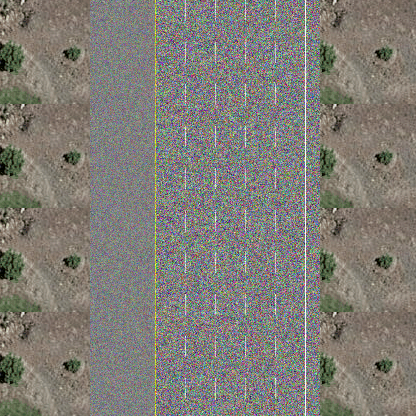

In [5]:
#img.save("/home/peo5032/Pictures/TESTER.png")
#img

index for channel road : 0


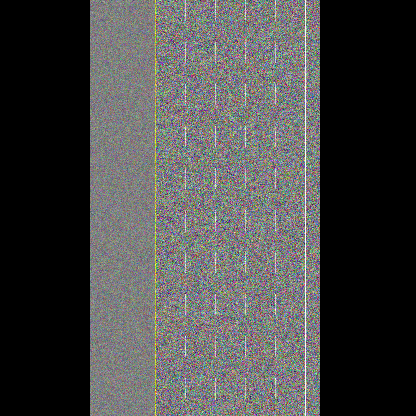

In [6]:
#test_tensor = torch.load('/home/peo5032/Desktop/tensor.pt')
#showInferenceOnImage(img, test_tensor, "road", 0.6, imageGen.classMap)

In [7]:
#img, test_tensor = rotationOfImageAndTensor(img, test_tensor, imageGen.classList, 90)

index for channel road : 0


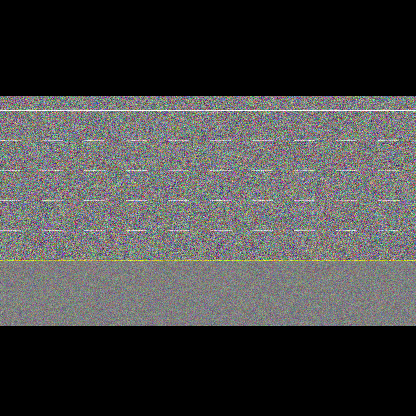

In [8]:
#showInferenceOnImage(img, test_tensor, "road", threshold=0.60,classMap=imageGen.classMap)
